<a href="https://colab.research.google.com/github/cromcruach52/Snapfolia-Leaf-Detection-and-Classification/blob/main/Leaf_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch-lr-finder

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install split-folders

In [ ]:
import os
import pandas as pd
import random
import seaborn as sns
import cv2
import torch
import torchvision
import shutil

from PIL import Image
from torch.utils.data import WeightedRandomSampler
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam

import torchvision.models as models
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import splitfolders
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# I. Data Preparation Phase

In [ ]:
leaf_path = "/content/drive/My Drive/Samples/Leaf_Samples/"
output_dir = "/content/drive/My Drive/Samples/splitted_dataS"
split_dataset(data_dir, output_dir)

In [ ]:
def sobel_edge_detection(image):
    image = np.array(image)
    channels = []
    for i in range(3):
        gray = image[:, :, i]
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel = np.sqrt(sobelx**2 + sobely**2)
        sobel = np.uint8(sobel)
        channels.append(sobel)
    sobel = np.stack(channels, axis=-1)
    return Image.fromarray(sobel)

class SobelEdgeDetection(object):
    def __call__(self, img):
        return sobel_edge_detection(img)

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    SobelEdgeDetection(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
class LeafDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        class_labels = sorted(os.listdir(root_dir))
        for label_idx, label in enumerate(class_labels):
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                for img_path in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_path)
                    self.image_paths.append(img_path)
                    label_vector = [0] * len(class_labels)
                    label_vector[label_idx] = 1
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)

In [ ]:
def visualize_images_before_after(dataset, transform, num_images=10):
    num_rows = (num_images + 1) // 2
    fig, ax = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))

    for i in range(num_images):
        row = i // 2
        col = (i % 2) * 2

        sample_index = random.randint(0, len(dataset) - 1)
        img_path, label = dataset.imgs[sample_index]

        img = Image.open(img_path).convert('RGB')
        ax[row, col].imshow(img)
        ax[row, col].title.set_text(f"Original Image - {'Leaf' if label == 0 else 'Non-Leaf'}")

        img_transformed = transform(img)
        img_transformed = img_transformed.permute(1, 2, 0).numpy()
        img_transformed = (img_transformed * 0.229) + 0.485
        ax[row, col + 1].imshow(img_transformed)
        ax[row, col + 1].title.set_text(f"Processed Image - {'Leaf' if label == 0 else 'Non-Leaf'}")

    plt.tight_layout()
    plt.show()

In [ ]:
def split_dataset(root_dir, output_dir, test_ratio=(10, 20)):
    class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_dir in class_dirs:
        class_path = os.path.join(root_dir, class_dir)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        random.shuffle(images)

        if len(images) < 100:
            num_test = test_ratio[0]
        else:
            num_test = test_ratio[1]

        test_images = images[:num_test]
        remaining_images = images[num_test:]

        os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_dir, img))


        remaining_dir = os.path.join(output_dir, 'remaining', class_dir)
        os.makedirs(remaining_dir, exist_ok=True)
        for img in remaining_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(remaining_dir, img))

    splitfolders.ratio(os.path.join(output_dir, 'remaining'), output=output_dir, seed=42, ratio=(.75, .25))


    shutil.rmtree(os.path.join(output_dir, 'remaining'))

In [ ]:
split_dataset(leaf_path, output_dir)

Copying files: 412 files [00:21, 19.00 files/s]


In [ ]:
# Load datasets
train = datasets.ImageFolder(root=os.path.join(output_dir, "train"), transform=data_transforms)
val = datasets.ImageFolder(root=os.path.join(output_dir, "val"), transform=data_transforms)
test = datasets.ImageFolder(root=os.path.join(output_dir, "test"), transform=data_transforms)

In [ ]:
train_loader = DataLoader(dataset=train,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True,
                             pin_memory=True)

val_loader = DataLoader(dataset=val,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True,
                             pin_memory=True)

test_loader = DataLoader(dataset=test,
                             batch_size=32,
                             num_workers=2,
                             shuffle=False,
                             pin_memory=True)

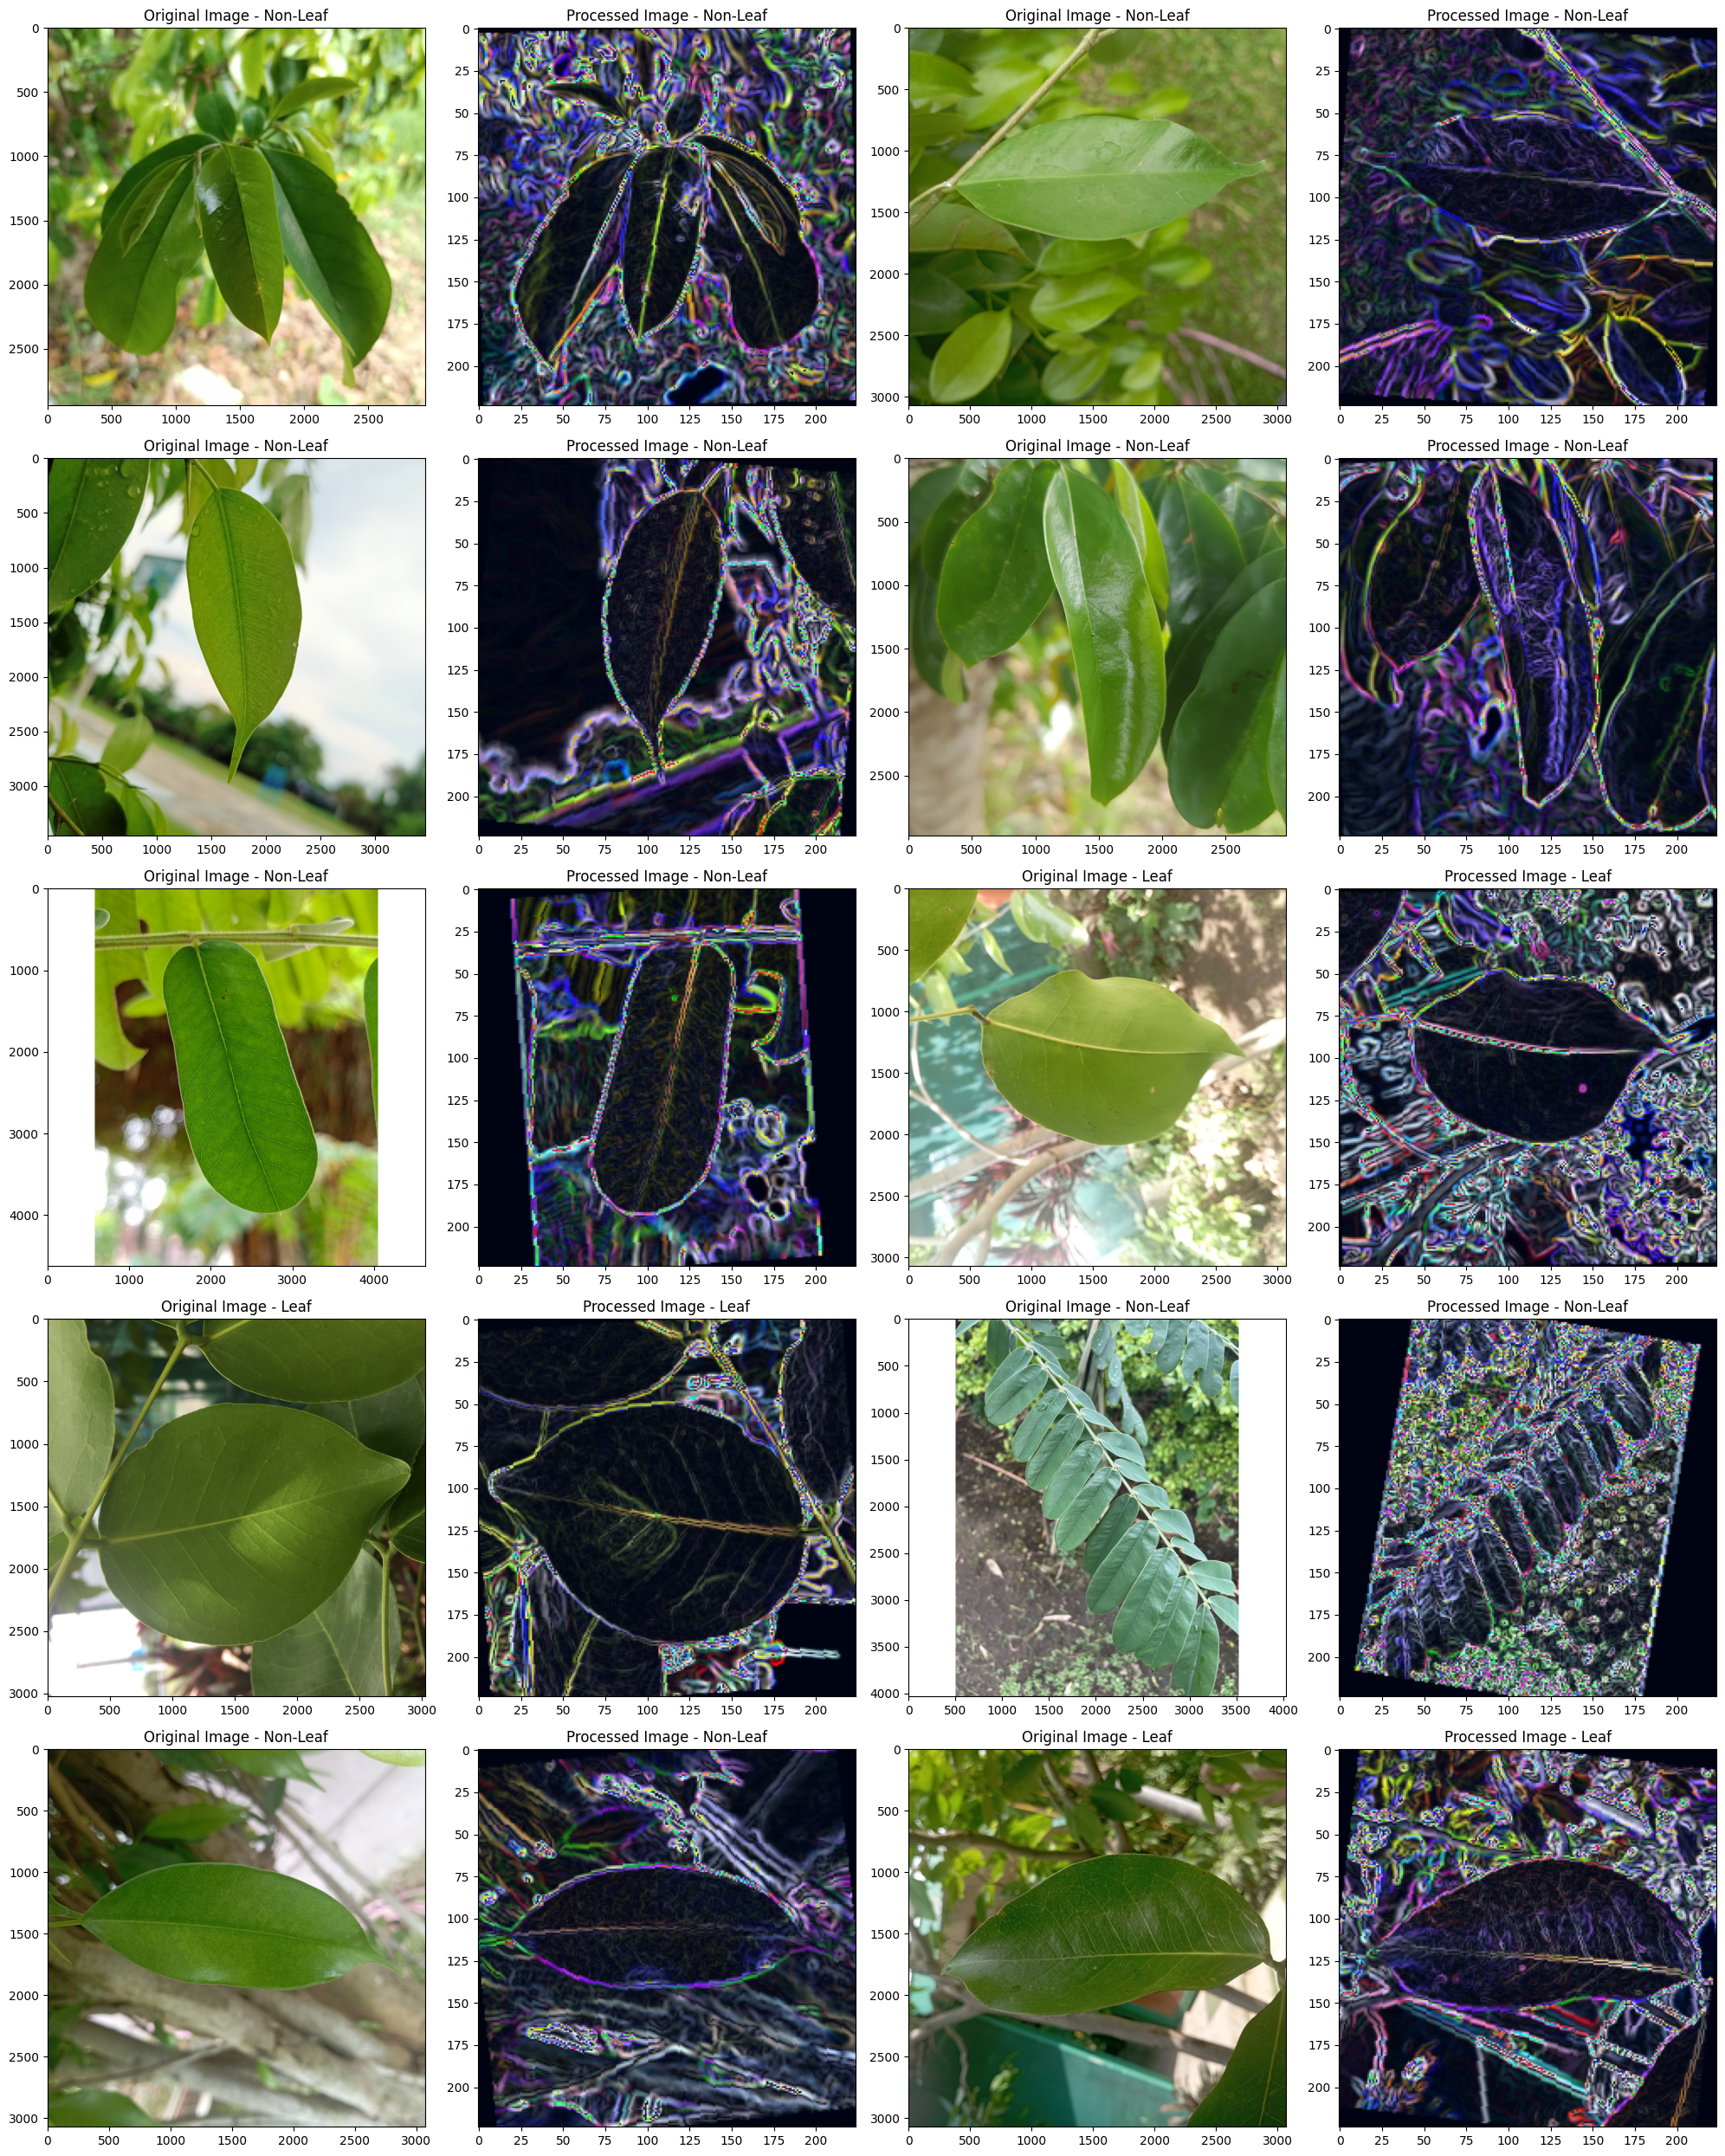

In [ ]:
visualize_images_before_after(train, data_transforms, num_images=10)

In [ ]:
class_to_idx = train.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Dataset Labels:\n", class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, val, test]):
    images_per_class = pd.Series([class_to_idx[dataset.classes[target]] for target in dataset.targets]).value_counts()
    print(f"Images per Class in {name}:")
    for idx in sorted(images_per_class.index):
        print(f"{idx}    {idx_to_class[idx]}: {images_per_class[idx]}")
    print()

Dataset Labels:
 {'Apitong': 0, 'Balayong': 1, 'Balete': 2, 'Bayabas': 3, 'Guyabano': 4} 

Images per Class in TRAIN:
0    Apitong: 84
1    Balayong: 40
2    Balete: 63
3    Bayabas: 60
4    Guyabano: 61

Images per Class in VALIDATION:
0    Apitong: 28
1    Balayong: 14
2    Balete: 21
3    Bayabas: 20
4    Guyabano: 21

Images per Class in TEST:
0    Apitong: 20
1    Balayong: 10
2    Balete: 20
3    Bayabas: 20
4    Guyabano: 10



# II. Model Setup Phase

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=models.ResNet50_Weights.DEFAULT)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 38.8MB/s]


In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 5)

In [ ]:
model = resnet.to(device)

# III. Loss Function and Optimizer Setup

In [ ]:
dataset = LeafDataset(leaf_path, transform=data_transforms)
class_labels = sorted(os.listdir(leaf_path))
num_ftrs = resnet.fc.in_features
num_classes = len(class_labels)
print("Class labels:", class_labels)

Class labels: ['Apitong', 'Balayong', 'Balete', 'Bayabas', 'Guyabano']


In [ ]:
total_samples = len(train)
samples_per_class = [len(os.listdir(os.path.join(leaf_path, label))) for label in class_labels]

print("Samples per class:", samples_per_class)

initial_class_weights = [total_samples / samples_per_class[i] for i in range(len(class_labels))]

class_weights = [np.log1p(weight) for weight in initial_class_weights]

print("Initial class weights:", initial_class_weights)
print("Log-scaled class weights:", class_weights)


weights = torch.tensor(class_weights).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)

Samples per class: [132, 64, 104, 100, 92]
Initial class weights: [2.3333333333333335, 4.8125, 2.9615384615384617, 3.08, 3.347826086956522]
Log-scaled class weights: [1.2039728043259361, 1.7600107709134747, 1.3766324502081537, 1.4060969884160703, 1.4696759700589417]


In [ ]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# IV. Training Phase

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, scheduler, num_epochs=64, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    early_stopping_counter = 0
    best_loss = float('inf')
    early_stop = False

    for epoch in range(num_epochs):
        if early_stop:
            print('Breaking out of epoch loop due to early stopping.')
            break

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {lr}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs
                labels = labels.long()

                labels = F.one_hot(labels, num_classes).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                preds = outputs > 0.5
                corrects = (preds == labels).sum().item()
                running_corrects += corrects
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects / (len(data_loader.dataset) * num_classes)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    print(f'Early stopping counter: {early_stopping_counter} out of {patience}')
                    if early_stopping_counter >= patience:
                        model.load_state_dict(best_model_wts)
                        print(f'Early stopping triggered.')
                        early_stop = True
                        break

    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, time_elapsed, best_loss, best_acc

model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc = train_model(model, criterion, optimizer, train_loader, val_loader, scheduler, num_epochs=64, patience=5)

torch.save(model.state_dict(), 'class_model.pth')

print("Training finished...\n")

Epoch 1/64
----------
Learning Rate: 0.001
train Loss: 0.6500 Acc: 0.8000
val Loss: 0.5725 Acc: 0.8000
Epoch 2/64
----------
Learning Rate: 0.001
train Loss: 0.5512 Acc: 0.8000
val Loss: 0.5224 Acc: 0.8000
Epoch 3/64
----------
Learning Rate: 0.001
train Loss: 0.5023 Acc: 0.8000
val Loss: 0.4790 Acc: 0.8019
Epoch 4/64
----------
Learning Rate: 0.001
train Loss: 0.4551 Acc: 0.8052
val Loss: 0.4400 Acc: 0.8077
Epoch 5/64
----------
Learning Rate: 0.001
train Loss: 0.4206 Acc: 0.8117
val Loss: 0.4087 Acc: 0.8192
Epoch 6/64
----------
Learning Rate: 0.001
train Loss: 0.3832 Acc: 0.8292
val Loss: 0.3958 Acc: 0.8327
Epoch 7/64
----------
Learning Rate: 0.001
train Loss: 0.3613 Acc: 0.8526
val Loss: 0.3594 Acc: 0.8577
Epoch 8/64
----------
Learning Rate: 0.001
train Loss: 0.3377 Acc: 0.8584
val Loss: 0.3494 Acc: 0.8731
Epoch 9/64
----------
Learning Rate: 0.001
train Loss: 0.3218 Acc: 0.8799
val Loss: 0.3296 Acc: 0.8712
Epoch 10/64
----------
Learning Rate: 0.001
train Loss: 0.3309 Acc: 0.874